# Insurance Fraud Claims Detection

## Premises

This notebook is based on the **Auto Insurance Claims Data** on Kaggle

https://www.kaggle.com/buntyshah/insurance-fraud-claims-detection

https://www.kaggle.com/buntyshah/auto-insurance-claims-data

The goal is not training the model. I need to explore the different approaches we have to write Production Code for Machine Learning Deployment.

## Libraries and Environments

In [1]:
# Data Sciences
import numpy as np 
import pandas as pd 

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Utils
import os

# Set notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
raw = '../data/raw/insurance_claims.csv'
interim = '../data/interim/'
processed= '../data/processed/'
models= '../models/'

## Data Analysis

### Read Data

In [3]:
data = pd.read_csv(raw)

# data shape
print(data.shape)

#visualize data
data.head()

(1000, 40)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


## Exploratory Data Analysis (EDA)

The dataset contains 1000 rows, one for each policy, and 40 columns or variables.

Let's identify...

1. Missing values
2. Numerical variables
3. Distribution of the numerical variables
4. Outliers
5. Categorical variables
6. Cardinality of the categorical variables
7. Potential relationship between the variables and the target: fraud_reported

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [5]:
data['_c39']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
995   NaN
996   NaN
997   NaN
998   NaN
999   NaN
Name: _c39, Length: 1000, dtype: float64

**Comment**

We notice that two variables have - as separator. 

Also we have a empty variables **_c39**

Finally, it seems that missing values in categorical variables are indicated with '?'

In [6]:
#Important - Data Engineering misses - in the variable below. Also we have _c39
data.drop('_c39', axis=1, inplace=True)
data.rename(columns={"capital-gains": "capital_gains", "capital-loss": "capital_loss"}, inplace=True)
data.to_csv(processed + 'sample.csv', index=False)

### Missing values

**Replace Missing values**

In [7]:
missing_variables= [col for col in data.select_dtypes(include='object').columns if any(data[col].str.contains('?', regex=False))]
data[missing_variables] = data[missing_variables].replace('?', np.nan)

### Target variable: fraud_reported

Text(0.5, 1.0, 'fraud_reported distribution')

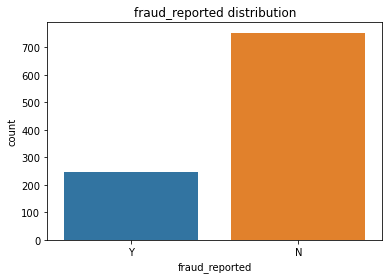

In [8]:
sns.countplot(data['fraud_reported'])
plt.title('fraud_reported distribution')

**Comment**

The sample is unbalanced. 

We have to convert into categorical

### Numerical variables

#### Numerical variables

In [9]:
numerical_variables = [col for col in data.columns if data[col].dtypes != 'object']

print('Number of numerical variables: ', len(numerical_variables))

data[numerical_variables].head()

Number of numerical variables:  18


,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
0,328,48,521585,1000,1406.91,0,466132,53300,0,5,1,1,2,71610,6510,13020,52080,2004
1,228,42,342868,2000,1197.22,5000000,468176,0,0,8,1,0,0,5070,780,780,3510,2007
2,134,29,687698,2000,1413.14,5000000,430632,35100,0,7,3,2,3,34650,7700,3850,23100,2007
3,256,41,227811,2000,1415.74,6000000,608117,48900,-62400,5,1,1,2,63400,6340,6340,50720,2014
4,228,44,367455,1000,1583.91,6000000,610706,66000,-46000,20,1,0,1,6500,1300,650,4550,2009


In [10]:
data[numerical_variables].describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


**Comment**

It seems policy_number is ID variable. We're going to drop it

In [11]:
policy_labels = len(data.policy_number.unique())

print('Number of labels: {}'.format(policy_labels))
    
print('Number of cases', len(data))

Number of labels: 1000
Number of cases 1000


#### Time variables

**Convert policy_bind_date and incident_date into datatime**

In [12]:
data['policy_bind_date'] = pd.to_datetime(data["policy_bind_date"])
data['incident_date'] = pd.to_datetime(data["incident_date"])

In [13]:
time_variables = [col for col in data.columns if 'year' in col or 'date' in col]
data[time_variables]

,policy_bind_date,incident_date,auto_year
0,2014-10-17,2015-01-25,2004
1,2006-06-27,2015-01-21,2007
2,2000-09-06,2015-02-22,2007
3,1990-05-25,2015-01-10,2014
4,2014-06-06,2015-02-17,2009
...,...,...,...
995,1991-07-16,2015-02-22,2006
996,2014-01-05,2015-01-24,2015
997,2003-02-17,2015-01-23,1996
998,2011-11-18,2015-02-26,1998


**Analyze the relationship between auto_year and the fraud_reported**

Text(0.5, 1.0, 'Change in House price with the years')

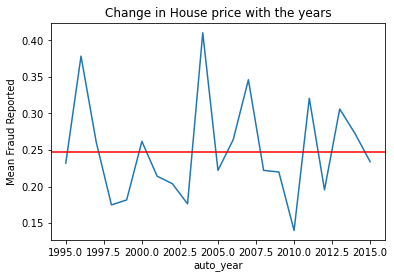

In [14]:
time_data = data.copy()
time_data['fraud_reported'] =  np.where(time_data['fraud_reported'] == 'Y', 1, 0)
time_data.groupby('auto_year')['fraud_reported'].mean().plot()
mean = time_data['fraud_reported'].mean()
plt.axhline(y=mean, color='r', linestyle='-')
plt.ylabel('Mean Fraud Reported')
plt.title('Change in House price with the years')

**Comment** : I was expected an different trend. For example, if the car is old I would fraud to get insurance premium

**Analyze the relationship between new variable, Time_to_incident and fraud_reported**

In [15]:
#Calculate the time_to_incident_days variable
time_data['time_to_incident_days'] = time_data['incident_date'] - time_data['policy_bind_date']
time_data['time_to_incident_days'] = time_data['time_to_incident_days'].dt.days
time_data['time_to_incident_months'] = time_data['time_to_incident_days'] / 30

#Binning time_to_incident_days variable
time_data['bin_dec'] = pd.qcut(time_data['time_to_incident_months'], q=10, precision=0)
time_data['bin_dec'].value_counts()

(281.0, 306.0]    100
(252.0, 281.0]    100
(222.0, 252.0]    100
(189.0, 222.0]    100
(156.0, 189.0]    100
(128.0, 156.0]    100
(97.0, 128.0]     100
(66.0, 97.0]      100
(30.0, 66.0]      100
(-2.0, 30.0]      100
Name: bin_dec, dtype: int64

Text(0.5, 1.0, 'Change in House price with the months')

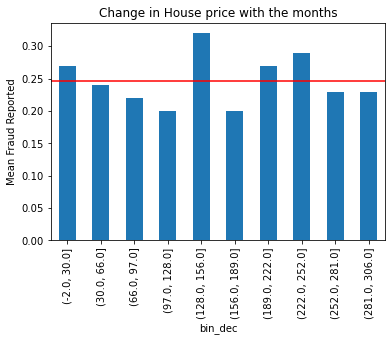

In [16]:
time_data.groupby('bin_dec')['fraud_reported'].mean().plot.bar()
mean = time_data['fraud_reported'].mean()
plt.axhline(y=mean, color='r', linestyle='-')
plt.ylabel('Mean Fraud Reported')
plt.title('Change in House price with the months')

**Comment**: The relationship seems to be significant. Also we have more likely to verify fraud after a month, between 4 and 5, between 7 and 8 and between 8 and 9 months of the policy bind. 
Also notice we have at least one wrong value cause the difference is negative. 
I will consider it anyway

In [17]:
print('The wrong record has policy number: {}'.format(time_data.sort_values('time_to_incident_months').iloc[0]['policy_number']))

The wrong record has policy number: 794731


#### Discrete variables

In [18]:
discrete_variables = [col for col in numerical_variables if len(data[col].unique()) < 30 and col not in time_variables] + missing_variables
data[discrete_variables].head()

,policy_deductable,umbrella_limit,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,collision_type,property_damage,police_report_available
0,1000,0,5,1,1,2,Side Collision,YES,YES
1,2000,5000000,8,1,0,0,NaN,NaN,NaN
2,2000,5000000,7,3,2,3,Rear Collision,NO,NO
3,2000,6000000,5,1,1,2,Front Collision,NaN,NO
4,1000,6000000,20,1,0,1,NaN,NO,NO


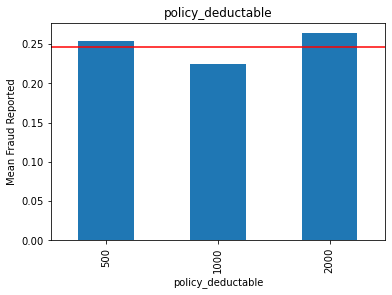

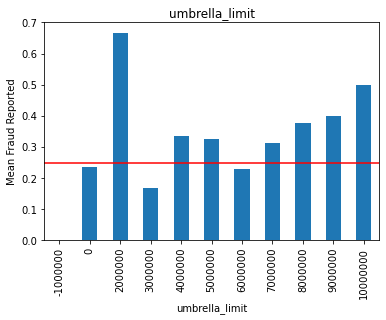

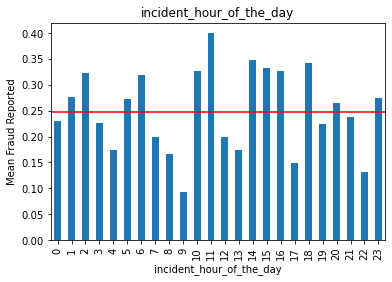

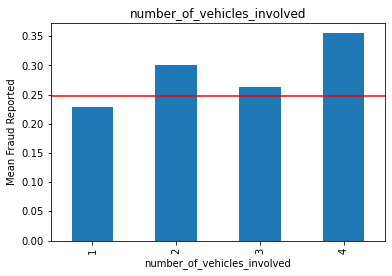

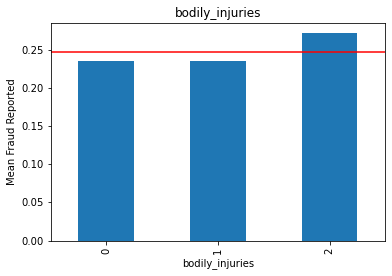

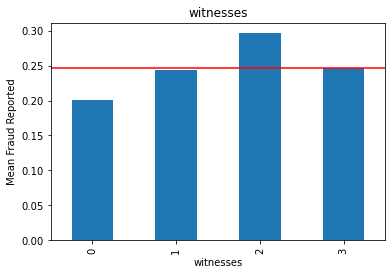

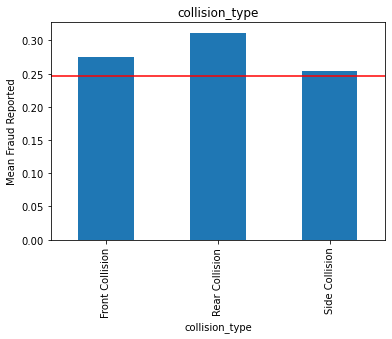

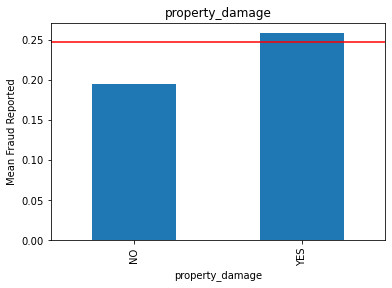

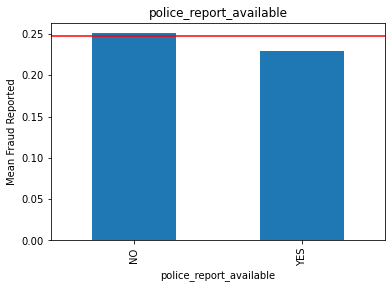

In [19]:
def plot_discrete(df, var):
    df = df.copy()
    # Dummy for target
    df['fraud_reported'] =  np.where(df['fraud_reported'] == 'Y', 1, 0)
    mean = df['fraud_reported'].mean()
     # Dummy for target
    df.groupby(var)['fraud_reported'].mean().plot.bar()
    plt.axhline(y=mean, color='r', linestyle='-')
    plt.title(var)
    plt.ylabel('Mean Fraud Reported')
    plt.show()
    
for var in discrete_variables:
    plot_discrete(data, var)

**Comment**:

policy deductable is how much of an insurance-covered expense is up to policyholder (customer). 

And umbrella limit is excess liability insurance. If a policyholder is sued for damages that exceed the liability limits of car insurance, an umbrella policy helps pay what they owe. 

All of them are significant

#### Continuous variables

In [23]:
continuous_variables = [col for col in numerical_variables if col not in discrete_variables + time_variables]

print('Number of continuous variables: ', len(continuous_variables))

data[continuous_variables].head()

Number of continuous variables:  11


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,total_claim_amount,injury_claim,property_claim,vehicle_claim
0,328,48,521585,1406.91,466132,53300,0,71610,6510,13020,52080
1,228,42,342868,1197.22,468176,0,0,5070,780,780,3510
2,134,29,687698,1413.14,430632,35100,0,34650,7700,3850,23100
3,256,41,227811,1415.74,608117,48900,-62400,63400,6340,6340,50720
4,228,44,367455,1583.91,610706,66000,-46000,6500,1300,650,4550


In [24]:
continuous_variables = [col for col in numerical_variables if col not in discrete_variables + time_variables and col not in ['insured_zip', 'policy_number', 'total_claim_anount']]

In [25]:
data[continuous_variables].shape

(1000, 9)

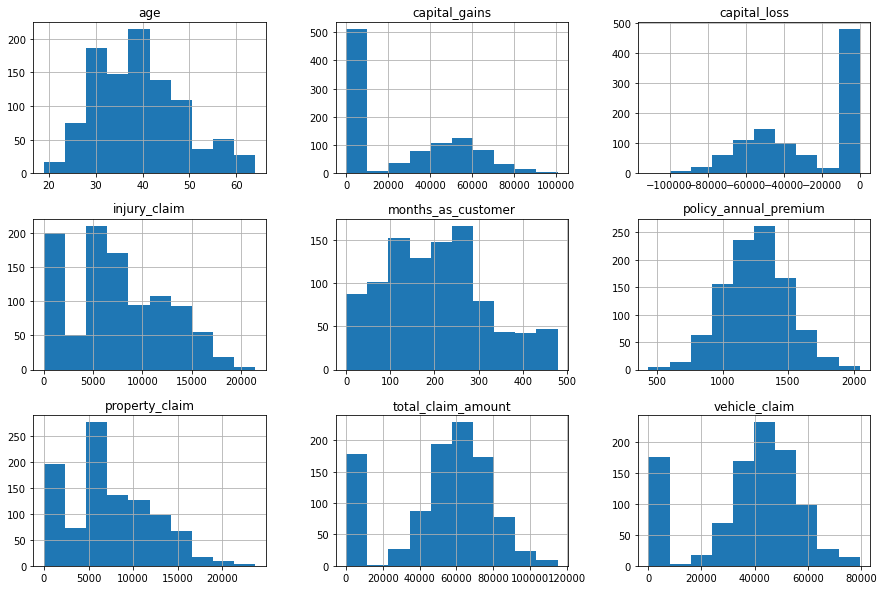

In [26]:
data[continuous_variables].hist(figsize = (15, 10));

**Comment**: Not all distributions are Normal. I'll drop the insurance zip and policy_number. Total_claim_anount is vehicle_claim + property_claim + injury_claim. I can consider to drop Total_claim_anount.
Also they have a different range

**Analyze the relationship between continuous variables and fraud_reported**

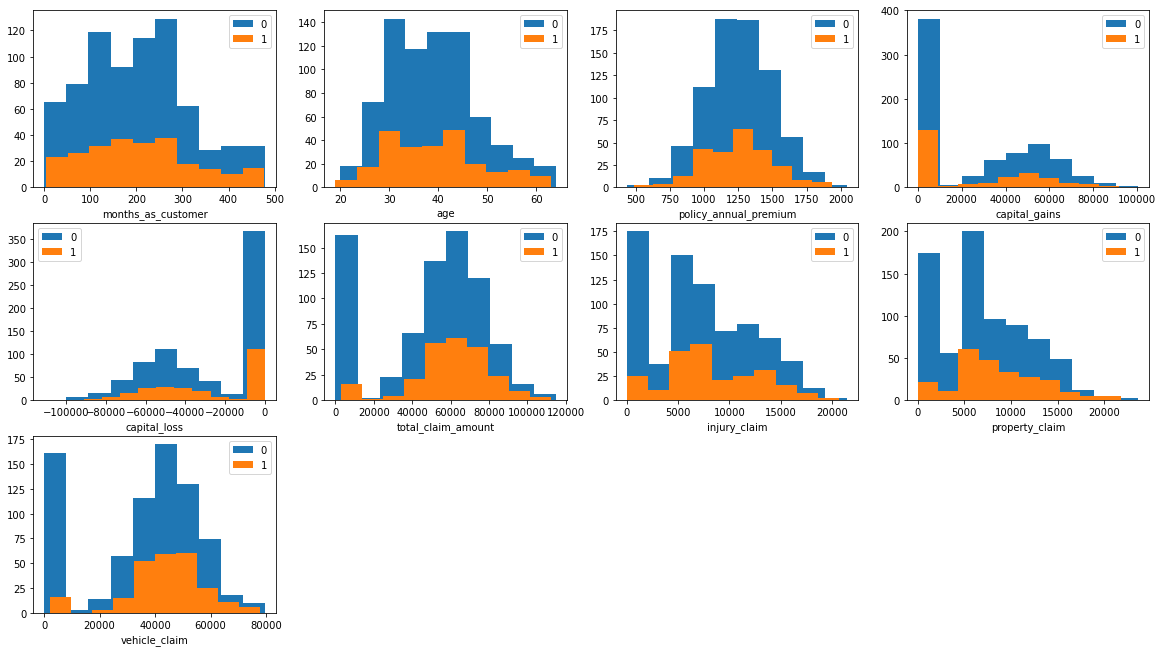

In [27]:
continuous_data = data.copy()
continuous_data['fraud_reported'] =  np.where(data['fraud_reported'] == 'Y', 1, 0)

colors = ['tab:blue', 'tab:orange']
plt.figure(figsize = (20, 15))
# plot histogram
index = 0
for feature in continuous_data[continuous_variables].columns:
    index += 1
    plt.subplot(4, 4, index)
    for label, color in zip(range(len(continuous_data['fraud_reported'].unique())), colors):
        plt.hist(continuous_data[continuous_data.fraud_reported==label][feature], 
                label = label, 
                color = color)
    plt.xlabel(feature)
    plt.legend()
plt.show()

**Comment**: Distributions seem quite similar between the two categories. 

**Outliers**

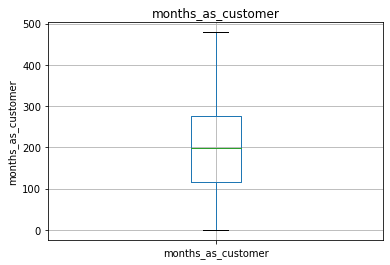

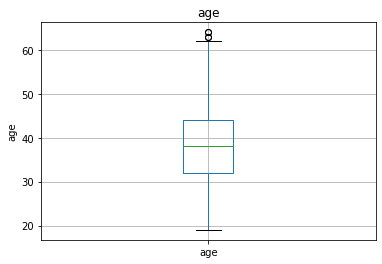

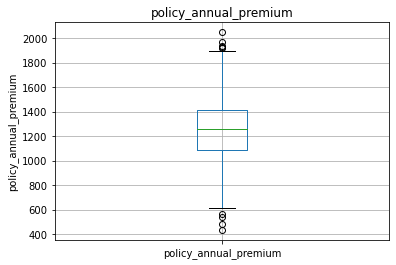

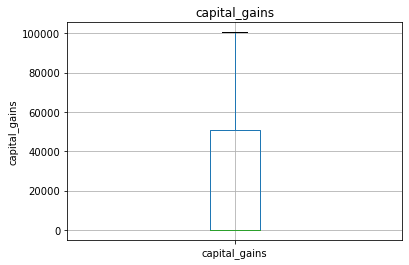

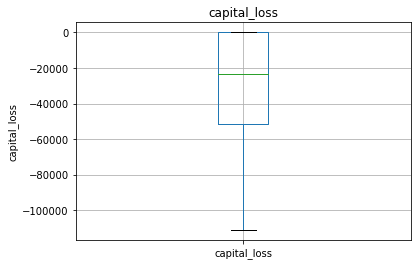

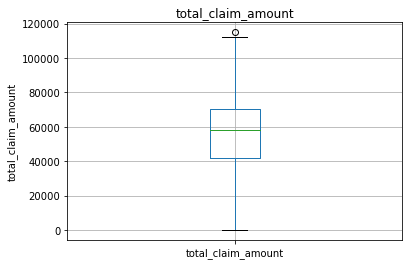

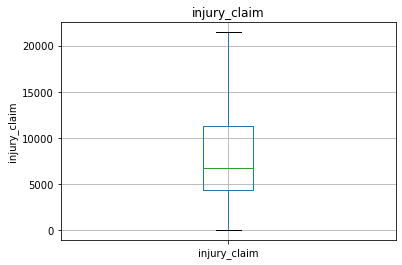

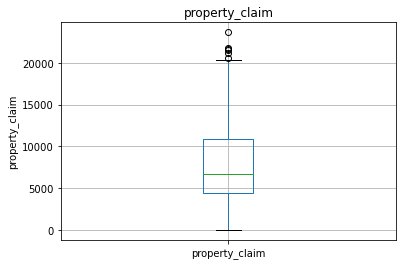

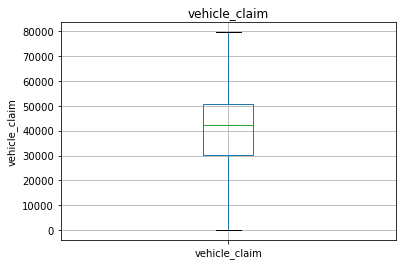

In [28]:
def outlier_tracker(df, var):
    df = df.copy()
    
    df.boxplot(column=var)
    plt.title(var)
    plt.ylabel(var)
    plt.show()


for var in continuous_variables:
    outlier_tracker(data, var)

**Comment**: We have some outliers and they may affect linear performance models.

### Categorical variables

In [31]:
categorical_variables = [col for col in data.columns if data[col].dtypes == 'object']

print('Number of categorical variables: ', len(categorical_variables))

data[categorical_vars].head()

Number of categorical variables:  19


,policy_state,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,property_damage,police_report_available,auto_make,auto_model,fraud_reported
0,OH,250/500,MALE,MD,craft-repair,sleeping,husband,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,YES,YES,Saab,92x,Y
1,IN,250/500,MALE,MD,machine-op-inspct,reading,other-relative,Vehicle Theft,NaN,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,NaN,NaN,Mercedes,E400,Y
2,OH,100/300,FEMALE,PhD,sales,board-games,own-child,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,NO,NO,Dodge,RAM,N
3,IL,250/500,FEMALE,PhD,armed-forces,board-games,unmarried,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,NaN,NO,Chevrolet,Tahoe,Y
4,IL,500/1000,MALE,Associate,sales,board-games,unmarried,Vehicle Theft,NaN,Minor Damage,None,NY,Arlington,3041 3rd Ave,NO,NO,Accura,RSX,N


**Comment**: We have some ordinal variable like incident_severity and insured_education_level. 

#### Check for cardinality

In [32]:
data[categorical_variables].nunique()

policy_state                  3
policy_csl                    3
insured_sex                   2
insured_education_level       7
insured_occupation           14
insured_hobbies              20
insured_relationship          6
incident_type                 4
collision_type                3
incident_severity             4
authorities_contacted         5
incident_state                7
incident_city                 7
incident_location          1000
property_damage               2
police_report_available       2
auto_make                    14
auto_model                   39
fraud_reported                2
dtype: int64

**Comment**: I'll drop incident_location and auto_model. Then, I'll not deal with cardinality cause it's low. 

#### Rare labels

In [34]:
def rare_analyzer(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['fraud_reported'].count() / len(df)
    
     # return categories that are rare
    return tmp[tmp < rare_perc]


for var in categorical_variables:
    print(rare_analyzer(data, var, 0.05))
    print()

Series([], Name: fraud_reported, dtype: float64)

Series([], Name: fraud_reported, dtype: float64)

Series([], Name: fraud_reported, dtype: float64)

Series([], Name: fraud_reported, dtype: float64)

Series([], Name: fraud_reported, dtype: float64)

insured_hobbies
base-jumping    0.049
basketball      0.034
board-games     0.048
chess           0.046
cross-fit       0.035
dancing         0.043
polo            0.047
skydiving       0.049
sleeping        0.041
Name: fraud_reported, dtype: float64

Series([], Name: fraud_reported, dtype: float64)

Series([], Name: fraud_reported, dtype: float64)

Series([], Name: fraud_reported, dtype: float64)

Series([], Name: fraud_reported, dtype: float64)

Series([], Name: fraud_reported, dtype: float64)

incident_state
OH    0.023
PA    0.030
Name: fraud_reported, dtype: float64

Series([], Name: fraud_reported, dtype: float64)

incident_location
1012 5th Lane       0.001
1028 Sky Lane       0.001
1030 Pine Lane      0.001
1087 Flute Drive    0.001

**Comment**: We have Rare labels issue at 0.05. In particular, auto_model and insured_hobbies are too sparse

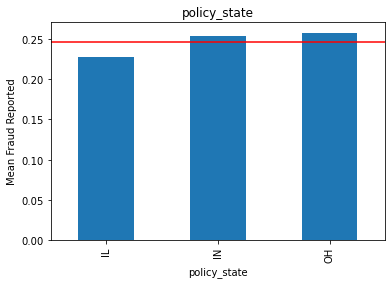

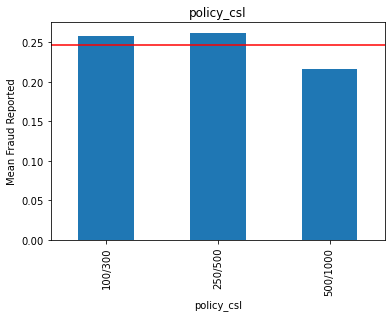

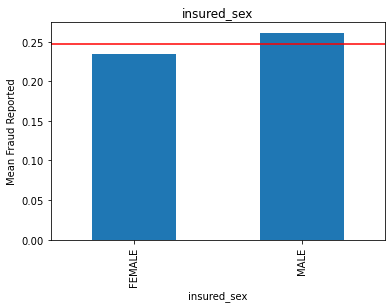

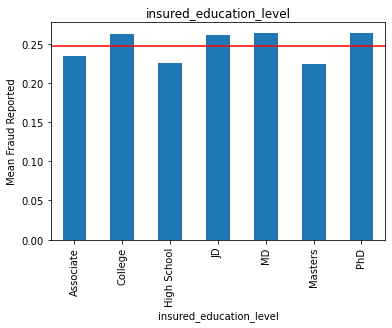

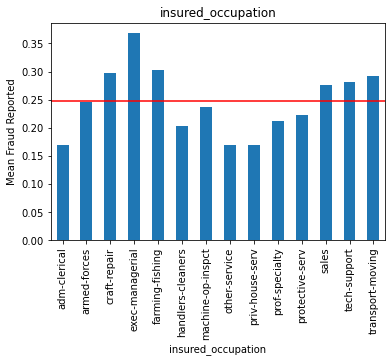

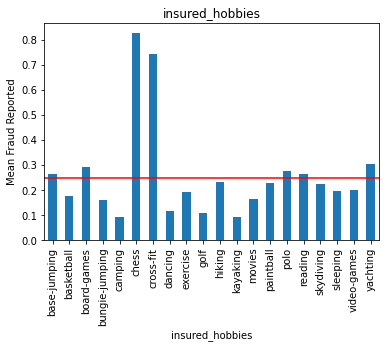

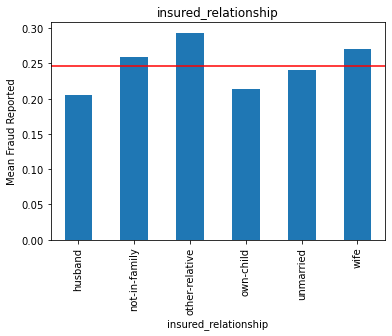

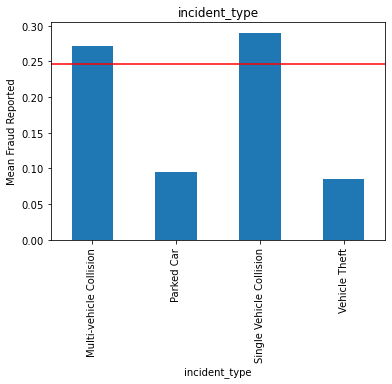

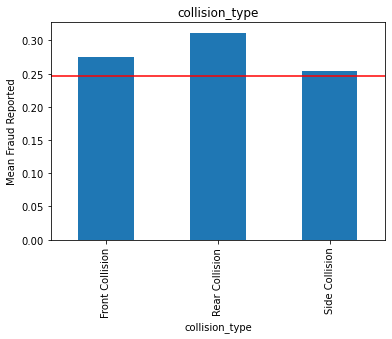

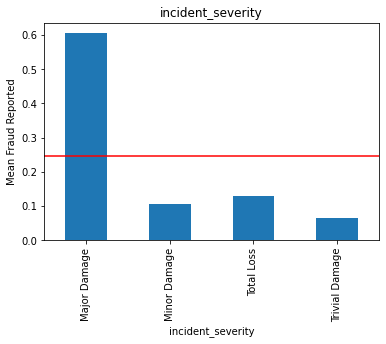

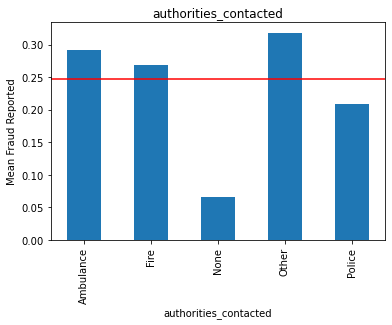

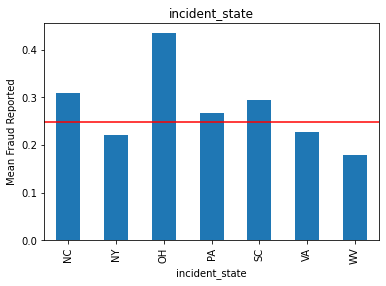

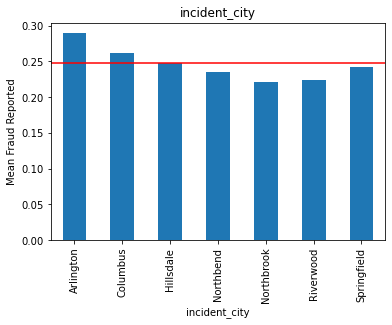

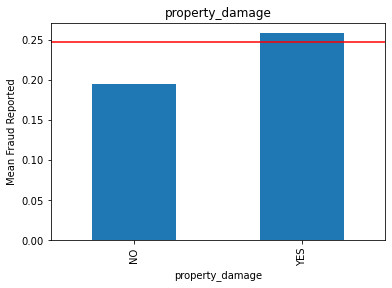

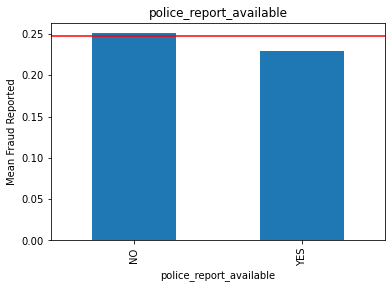

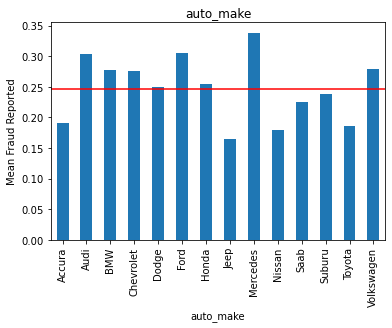

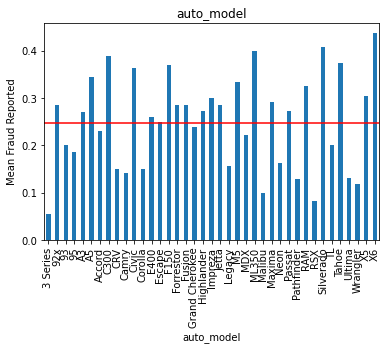

In [36]:
rem_vars = ['fraud_reported', 'incident_location']
catforplot = [var for var in categorical_variables if var not in rem_vars]
for var in catforplot:
    plot_discrete(data, var)

**Comment**: All of them seem to be significant

## Final Comment

We're ready to move on Feature engineering part. 

And we have 

1. Assess missing in ['collision_type', 'property_damage', 'police_report_available']
2. Convert string in datetime in ['policy_bind_date', 'incident_date']
3. Assess umbrella_limit variable
4. Not all distributions are Normal. I'll drop the insurance zip, policy_number and Total_claim_anount
5. age and capital loss
6. They have a different range